<div>
<center>
    <img src="https://datascientest.fr/train/assets/logo_datascientest.png", style="height:150px">
</center> 
</div>

<hr style="border-width:2px;border-color:##75DFC1">
<br>
<center> <h1> Segmentation de régions nuageuses </h1> </center> <br><br>
<center> <h2> Phase 2 - Multi-Classification </h2> </center> <br><br>
<hr style="border-width:2px;border-color:##75DFC1">

<div class="panel" style="border-width:2px;border-color:##75DFC1"> 
    <div class="panel-body">
<h3> Contexte du sujet </h3>
<p>Il s’agit d’analyser et d’identifier dans chaque image satellite les régions qui contiennent une formation nuageuse parmi : poisson, fleur, gravier, sucre. Ces segmentations aident à la projection climatique en permettant de démystifier une des variables importantes du climat.</p>
        
<h3>Data</h3>
<p>Les données sont des images satellites labellisées, un set de donnée test non labellisé est disponible.<br>
[Données Kaggle]<span style="color:#660099;">
    <a href="https://www.kaggle.com/c/understanding_cloud_organization/">
        https://www.kaggle.com/c/understanding_cloud_organization/></a></p>

<h3> Objet </h3>
<p>Cette phase consiste a implémenter un modèle de multi-classification des images satellites afin d'identifier la présence ou l'absence dans l'image des quatre classes de formations nuageuses : poisson, fleur, gravier, sucre.</p>

</div>       
</div>

### Groupe
> * Cathy Baynaud-Samson,
> * Yann Bernery
> * José Castro
> * Ludovic Changeon

## **1 - Import des librairies**


In [ ]:
# Création de répertoires pour stocker le Git, les librairies et checkpoints
!mkdir nebulaTemp -p
!mkdir packages -p
!mkdir chkpt_classif -p

# Copie des sources des librairies projet depuis le Github
!git clone https://github.com/DataScientest/nebula/ ./nebulaTemp --dissociate
#!git clone --single-branch --branch ludovic https://github.com/DataScientest/nebula/ ./nebulaTemp --dissociate

# Répartition des différentes ressources dans les répertoires
!cp ./nebulaTemp/packages/* ./packages
!cp ./nebulaTemp/resources/chkpt_classif/* ./chkpt_classif

# Suppression de la copie du repository source
!rm nebulaTemp -r

Cloning into './nebulaTemp'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 275 (delta 113), reused 146 (delta 83), pack-reused 73
Receiving objects: 100% (275/275), 37.80 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [ ]:
# Import des librairies du projet
import packages

# Librairies génériques
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random

# Librairies images
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
from   PIL import Image
import cv2

# Interface CNN Keras
from   tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from   tensorflow.keras.optimizers import Adam
from   tensorflow.keras.models import Model, Sequential
from   tensorflow.keras.utils import to_categorical

# Scikit Learn
import sklearn
from   sklearn.feature_selection import VarianceThreshold
from   sklearn.metrics import classification_report, f1_score
from   sklearn.model_selection import GridSearchCV, train_test_split

# Compléments tensorflow
import tensorflow as tf
from   tensorflow.keras.preprocessing import image
from   tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

## **2 - Import des données**

Les images compressées sont copiées dans le répertoire courant depuis un lien google drive prédéfini. Elles sont ensuite décompressées.  
A noter que les images ont au préalable fait l'objet d'une réduction, dans le but de gagner d'une part en espace de stockage et d'autre part en temps d'exécution. Il est en effet possible de les charger en mémoire.  
Note : il est nécessaire d'installer la librairie gdown au préalable.

In [ ]:
pip install gdown

In [ ]:
import gdown
gdown.download('https://drive.google.com/uc?id=1ptRUA_Kou4DpkDHdQFfhq60r6EcvF4Ue',
               'cloud_training_8.zip', quiet=False)
!unzip cloud_training_8.zip > /dev/null
!rm cloud_training_8.zip

Downloading...
From: https://drive.google.com/uc?id=1ptRUA_Kou4DpkDHdQFfhq60r6EcvF4Ue
To: /content/cloud_training_8.zip
147MB [00:03, 45.3MB/s]


'cloud_training_8.zip'

## **3 - Pré-traitement des données**

### **3.1 - Chargement et codage disjonctif des classes de nuages**

On récupère le contenu de l'index des images et on crée les indices des classes.

In [ ]:
df = packages.load_train(filename = 'train.csv')
train_partial = packages.label_parsing(dataframe=df, sep='_',drop_na=True)
train_encoded = packages.one_hot_encoding(dataframe=train_partial, reset_index = False)
train_encoded.head(3)

Fish  Flower  Gravel  Sugar
image                                   
0011165.jpg     1       1       0      0
002be4f.jpg     1       1       0      1
0031ae9.jpg     1       1       0      1

Des dataframes sont créés pour faciliter les traitements.

In [ ]:
#Affectation de data (sous forme de nom des images) et target
data = pd.DataFrame(train_encoded.index.values,columns = ['nom'])
labels = train_encoded.columns
target = pd.DataFrame(train_encoded.values.astype('float32'),
                      columns=labels,
                      index=train_encoded.index)

### **3.2 - Chargement et séparation des images**



Nous réservons ici 5% des images du set d'apprentissage pour effectuer des tests.  
Ainsi nous nous assurons que le modèle n'aura jamais vu ces images.

In [ ]:
# Définition des paramètres
originalSize = (1400, 2100) # la taille originale de toutes les images identifié en phase 1
preload = 0 # chargement des images en mémoire (1) ou pas (0)
ratio = 1/8 # facteur de réduction (pour info)
repTrain  = 'train_images_8/'

# Initialisation des tailles cibles
tx = np.int(originalSize[0]*ratio)
ty = np.int(originalSize[1]*ratio)

# Initialisation des tailles d'images
path = os.path.join(repTrain, data['nom'][0])
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
tailleChargement = img.shape

# On charge les images dans data_full
data_full=data

# On sépare les données en 'train' / 'test', on met de côté 'test' pour la fin
X_data, X_test, y_data, y_test = packages.splitValid(data_full, 
                                                     target, 
                                                     randomState=123, 
                                                     test_size=0.0461, 
                                                     shuffle = True)

On vérifie les proportions de chacune des classes afin de contrôler qu'il n'y a aucun déséquilibre préjudiciable pour la suite de la procédure.

In [ ]:
# Vérifications des proportions pour chacun des sous-ensembles
proportions = [y_data.iloc[:,j].value_counts(normalize=True) for j in range(4)]
for j in range(len(labels)):
    print('Classe ', labels.values[j])

    for i,k in enumerate(proportions[j]): 
        print('    Flag {} : {:2.0%}'.format(i, k)) 

Classe  Fish
    Flag 0 : 50%
    Flag 1 : 50%
Classe  Flower
    Flag 0 : 57%
    Flag 1 : 43%
Classe  Gravel
    Flag 0 : 53%
    Flag 1 : 47%
Classe  Sugar
    Flag 0 : 68%
    Flag 1 : 32%


## **4 - Implémentation du modele**


### **4.1 - Spécification de l'architecture du modèle de classification**

On initialise un modèle CNN intégrant :  
* deux couches de convolution / max pooling
* deux couches de neurones (Dense layers).

La fonction de création "buildClassifModel" a été déportée dans la librairie projet pour plus de commodité.

In [ ]:
model = packages.builClassifModel()  
model.summary()

modelW = packages.NebulaWrapper(model, autoInit=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 171, 258, 30)      780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 51, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 47, 8)         6008      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 9, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 9, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 432)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

### **4.2 - Représentation intermédiaire des couches du modele**

Exploration du modèle via une image de démonstration

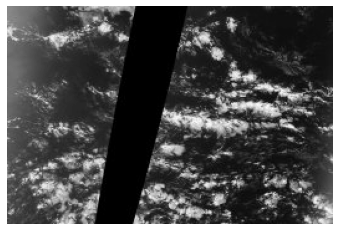

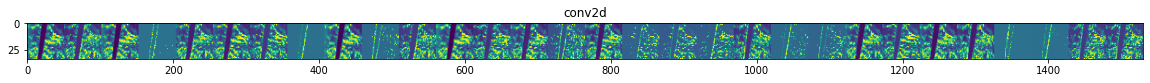

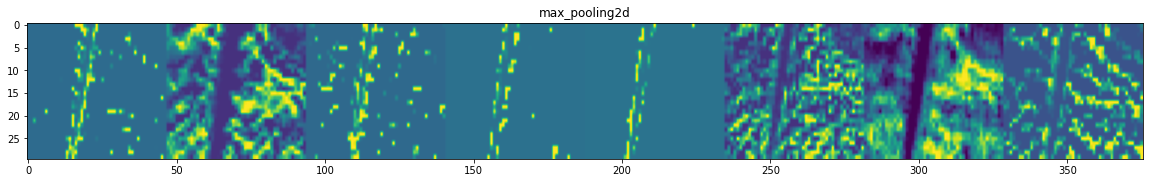

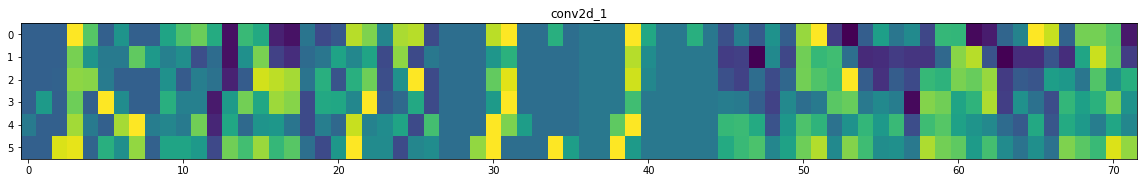

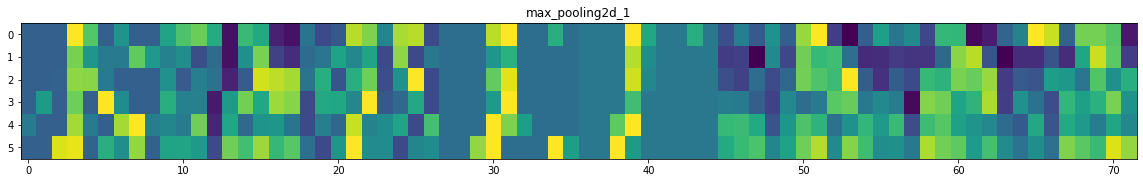

In [ ]:
# Nous définissons une instance de notre modèle qui va prendre en entrée une image
# et retourner une représentation intermédiaire des couches (en dehors de
# la première)
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img_test = '0a709e6.jpg'
img_path = os.path.join(repTrain, img_test)
img = load_img(img_path, target_size=(tx, ty), color_mode="grayscale") 
#Affichage de l'image originale
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()

x   = img_to_array(img)                          
x   = x.reshape((1,) + x.shape)                  
# Normalisation
x /= 255.0

# Nous lançons notre image à travers le modèle
successive_feature_maps = visualization_model(x)

# Nous récupérons les noms des couches de notre modèle
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Affichage des représentations intermédiaires
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:
    
        #-------------------------------------------
        # Le traitement est réalisé uniquement sur les couches de convolution et max-pooling
        # et non sur les couches denses
        #-------------------------------------------
        n_features = feature_map.shape[-1]   # number of features in the feature map
        sizew       = feature_map.shape[ 1]  # feature map shape (1, sizew, sizeh, n_features)
        sizeh       = feature_map.shape[ 2]

        # dimensionnement d'une grille
        display_grid = np.zeros((sizew, sizeh * n_features))
    
        #-------------------------------------------------
        # traitement de préparation à la visualisation
        #-------------------------------------------------
        for i in range(n_features):
            y  = np.array(feature_map[0, :, :, i])
            y -= y.mean()
            y /= y.std ()
            y *=  64
            y += 128
            y  = np.clip(y, 0, 255).astype('uint8')
            display_grid[:, i * sizeh : (i + 1) * sizeh] = y

        #-----------------
        # Affichage de la grille
        #-----------------
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## **5 - Compilation et entraînement**

Paramètres et première préparation du jeu de données

In [ ]:
checkpointPath = 'chkpt_classif/'
checkpointBase = checkpointPath + 'multiclassif'  #'/content/drive/MyDrive/checkpoints/checkpointTest' #checkpoint2
batchSize = 32
epochs = 20
class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}

# Les données et le modèle sont préparés "à blanc", au cas où on ne souhaiterait que recharger des poids d'un entraînement précédent
X_train, X_valid, y_train, y_valid = packages.splitValid(X_data, y_data,
                                                         randomState=123, test_size=0.2,
                                                         shuffle=False) # séparation train / valid

trainGen = packages.makeGen(X_train, y_train,
                            folder=repTrain, batchSize=batchSize,
                            target_size=(tx, ty), nb_canaux=1) # Création ImageGenerators
validGen = packages.makeGen(X_valid, y_valid,
                            folder=repTrain, batchSize=batchSize,
                            target_size=(tx, ty), nb_canaux=1)

# Compilation
modelW.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=.001) ,
               metrics = ['categorical_accuracy'])

Found 4232 validated image filenames.
Found 1058 validated image filenames.


Entraînement du modèle. Nous procédons en trois phases successives pendant lesquelles la répartition des images entre l'ensemble d'apprentissage et l'ensemble de validation est aléatoirement remaniée.

In [ ]:
# Affichage optionnel de tous les epochs
verboseTraining = 1
#=====================Phase 1
print("Début phase 1...")
checkpoint = checkpointBase + '_phase1'
lstCallbacks = [packages.cb_modelCheckPoint(checkpoint),
                packages.cb_reduceLr(patience =2, factor = 0.2)]
#Entraînement
training1 = modelW.fit(trainGen,
                       steps_per_epoch = len(X_train)//batchSize,
                       epochs = epochs,
                       validation_data = validGen,
                       validation_steps = len(X_valid)//batchSize,
                       callbacks = lstCallbacks,  class_weight = class_weights,
                       verbose = verboseTraining)

#=====================Phase 2
print("\n\nDébut phase 2...")
X_train, X_valid, y_train, y_valid = packages.splitValid(X_data, y_data, randomState=124, test_size=0.2, shuffle=False)
trainGen = packages.makeGen(X_train, y_train,
                            folder=repTrain, batchSize=batchSize,
                            target_size=(tx, ty), nb_canaux=1) # Création ImageGenerators
validGen = packages.makeGen(X_valid, y_valid,
                            folder=repTrain, batchSize=batchSize,
                            target_size=(tx, ty), nb_canaux=1)

checkpoint = checkpointBase + '_phase2'
lstCallbacks = [packages.cb_modelCheckPoint(checkpoint)]

modelW.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=.001) ,
               metrics = ['categorical_accuracy'])
#Entraînement
training2 = modelW.fit(trainGen,
                       steps_per_epoch = len(X_train)//batchSize,
                       epochs = epochs,
                       validation_data = validGen,
                       validation_steps = len(X_valid)//batchSize,
                       callbacks = lstCallbacks,  class_weight = class_weights,
                       verbose = verboseTraining)

#=====================Phase 3
print("\n\nDébut phase 3...")
# On pénalise plus fortement les classes moins bien détectées
class_weights = {0: 5., 1: 5., 2: 5., 3: 1.}
X_train, X_valid, y_train, y_valid = packages.splitValid(X_data, y_data, randomState=3, test_size=0.2, shuffle=False)
trainGen = packages.makeGen(X_train, y_train,
                            folder=repTrain, batchSize=batchSize,
                            target_size=(tx, ty), nb_canaux=1) # Création ImageGenerators
validGen = packages.makeGen(X_valid, y_valid,
                            folder=repTrain, batchSize=batchSize,
                            target_size=(tx, ty), nb_canaux=1)

checkpoint = checkpointBase + '_phase3'
lstCallbacks = [packages.cb_modelCheckPoint(checkpoint)]

modelW.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=.0001) ,
               metrics = ['categorical_accuracy'])
#Entraînement
training3 = modelW.fit(trainGen,
                       steps_per_epoch = len(X_train)//batchSize,
                       epochs = epochs,
                       validation_data = validGen,
                       validation_steps = len(X_valid)//batchSize,
                       callbacks = lstCallbacks,  class_weight = class_weights,
                       verbose = verboseTraining)

print('\n\nFin de l\'entraînement')

Début phase 1...
Epoch 1/20
132/132 [==============================] - 5s 35ms/step - loss: 0.6777 - categorical_accuracy: 0.0783 - val_loss: 0.6779 - val_categorical_accuracy: 0.0871
Epoch 2/20
132/132 [==============================] - 4s 33ms/step - loss: 0.6658 - categorical_accuracy: 0.0917 - val_loss: 0.6600 - val_categorical_accuracy: 0.1297
Epoch 3/20
132/132 [==============================] - 4s 33ms/step - loss: 0.6471 - categorical_accuracy: 0.1750 - val_loss: 0.6367 - val_categorical_accuracy: 0.2509
Epoch 4/20
132/132 [==============================] - 4s 33ms/step - loss: 0.6313 - categorical_accuracy: 0.2071 - val_loss: 0.6248 - val_categorical_accuracy: 0.3542
Epoch 5/20
132/132 [==============================] - 4s 32ms/step - loss: 0.6178 - categorical_accuracy: 0.2302 - val_loss: 0.6301 - val_categorical_accuracy: 0.1373
Epoch 6/20
132/132 [==============================] - 4s 32ms/step - loss: 0.6062 - categorical_accuracy: 0.2407 - val_loss: 0.6049 - val_categorica

## **6 - Evaluation du modele**

### **6.1 - Evolution de la perte et de la précision**

On se prépare à sauvegarder chacune des variables d'intérêt (précision / perte pour chacune des phases training / validation)

In [ ]:
precision = 'categorical_accuracy'
val_precision = 'val_categorical_accuracy'
perte = 'loss'
val_perte = 'val_loss'

variables = [precision, val_precision, perte, val_perte]

Une fonction est définie permettant de concaténer les résultats des différentes phases d'entraînement

In [ ]:
def saveHistory(training, sauvegarde, vars):
  if len(sauvegarde[0])==0: # si l'historique est vide, créer les variables
    for i, val in enumerate(vars):
      sauvegarde[i]=training.history[val]
  else:                     # sinon, ajouter l'historique en queue
      for i, val in enumerate(vars):
        temp=sauvegarde[i]
        temp.extend(training.history[val])
        sauvegarde[i]=temp
  return sauvegarde

On réalise ensuite la concaténation des trois phases d'entraînement

In [ ]:
sauvegarde = [[], [], [], []]
sauvegarde = saveHistory(training1, sauvegarde, variables)
sauvegarde = saveHistory(training2, sauvegarde, variables)
sauvegarde = saveHistory(training3, sauvegarde, variables)

Finalement on trace les graphiques pour illustrer l'entraînement

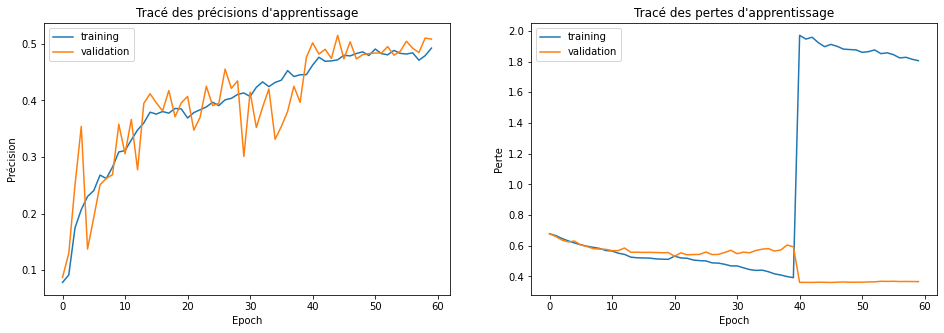

In [ ]:
fig,ax = plt.subplots(nrows = 1, ncols =2, figsize = (16,5))
# Graphique des précisions
ax[0].plot(sauvegarde[0],label = 'training')
ax[0].plot(sauvegarde[1], label = 'validation')
ax[0].set_title('Tracé des précisions d\'apprentissage')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Précision')
ax[0].legend()
#Graphique des pertes
ax[1].plot(sauvegarde[2],label = 'training')
ax[1].plot(sauvegarde[3],label = 'validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Perte')
plt.title('Tracé des pertes d\'apprentissage')
plt.legend()
plt.show()

### **6.2 - Prédictions et score F1 par classe au seuil par défaut (set de test)**


Création d'un générateur d'images de test

In [ ]:
# Création d'un générateur de test
testGen = packages.makeGen(X_test, y_test, folder=repTrain, batchSize=batchSize, target_size=(tx, ty), nb_canaux=1)

Found 256 validated image filenames.


 Utilisation de la fonction d'évaluation interne du modèle

In [ ]:
# Récupération du checkpoint
modelW.model.load_weights(checkpointPath+'checkpoint3')

# Evaluation du modèle
evaluation = modelW.evaluate(testGen, steps = len(y_test)//batchSize)

8/8 [==============================] - 0s 24ms/step - loss: 0.5495 - categorical_accuracy: 0.4141


Observation des résultats par classe

*   Définition d'une fonction d'évaluation



In [ ]:
# Fonction d'affichage de l'évaluation détaillée
## 1: classification_report
## 2: matrices de confusion par classe

def crosstabsFromX(dataGen, target, seuil, batchSize):
  y_pred = modelW.predict(dataGen, batch_size=batchSize, steps=None)
  y_pred_final = np.empty((y_pred.shape[0],y_pred.shape[1]))
  for i in range(len(y_pred[:])):
      for j in range(4):
          y_pred_final[i] = np.where(y_pred[i,:]>=seuil,1,0)
  print(classification_report(target, y_pred_final, zero_division = 0))
  for i in range(4):
      y_pred_cx = y_pred_final[:,i]
      y_test_cx = target.iloc[:,i]
      print(labels[i])
      print((pd.crosstab(y_test_cx,y_pred_cx,rownames=['Réel'], colnames=['Prédit'],normalize=True)).round(2)*100)
      print()
  return y_pred_final

* Application de la fonction aux données de test isolées au début

In [ ]:
# Choix d'un seuil de 0.4 (meilleur f1-score)
y_pred_final = crosstabsFromX(testGen, y_test, 0.4, 32)

              precision    recall  f1-score   support

           0       0.57      0.81      0.67       127
           1       0.63      0.73      0.68       102
           2       0.65      0.88      0.74       141
           3       0.74      0.94      0.83       179

   micro avg       0.66      0.86      0.74       549
   macro avg       0.65      0.84      0.73       549
weighted avg       0.66      0.86      0.74       549
 samples avg       0.68      0.88      0.73       549

Fish
Prédit   0.0   1.0
Réel              
0.0     20.0  30.0
1.0      9.0  40.0

Flower
Prédit   0.0   1.0
Réel              
0.0     43.0  17.0
1.0     11.0  29.0

Gravel
Prédit   0.0   1.0
Réel              
0.0     18.0  27.0
1.0      7.0  48.0

Sugar
Prédit  0.0   1.0
Réel             
0.0     7.0  23.0
1.0     4.0  66.0



On évalue la qualité des prédictions sur base des f1-score de chacune des classes. Le f1-score mini est à 66% et le maxi à 84%, ce qui est un résultat acceptable.

### **6.3 - Evaluation du set complet**

On évalue tout le jeu de données, classe par classe

In [ ]:
fullGen = packages.makeGen(data_full, target.iloc[:,:4], folder = repTrain, batchSize = batchSize, target_size=(tx, ty), nb_canaux=1)
y_pred_final = crosstabsFromX(fullGen, target.iloc[:,:4], 0.4, 32)
prediction = pd.DataFrame(y_pred_final, index = target.iloc[:,:4].index, columns = target.iloc[:,:4].columns)

Found 5546 validated image filenames.
              precision    recall  f1-score   support

           0       0.64      0.87      0.74      2781
           1       0.74      0.84      0.79      2365
           2       0.66      0.91      0.76      2939
           3       0.75      0.96      0.84      3751

   micro avg       0.70      0.90      0.79     11836
   macro avg       0.70      0.90      0.78     11836
weighted avg       0.70      0.90      0.79     11836
 samples avg       0.72      0.92      0.77     11836

Fish
Prédit   0.0   1.0
Réel              
0.0     26.0  24.0
1.0      6.0  44.0

Flower
Prédit   0.0   1.0
Réel              
0.0     45.0  13.0
1.0      7.0  36.0

Gravel
Prédit   0.0   1.0
Réel              
0.0     22.0  25.0
1.0      5.0  48.0

Sugar
Prédit   0.0   1.0
Réel              
0.0     11.0  21.0
1.0      3.0  65.0



Globalement les niveaux de f1-score augmentent (c'est attendu puisque l'on a intégré les données d'entraînement). Mais les niveaux restent proches de l'ensemble de test seul, le modèle n'a pas sur-appris.

### **6.4 - Confusion du modele**

Nous établirons par la suite des scores de prédiction par image précis, cependant nous pouvons nous concentrer tout d'abord sur le nombre de classes correctement prédites pour chaque image.

Ainsi nous créons un score de confusion pour chaque image avec les caractéristiques suivantes
* une classe présente correctement prédite présente : +1
* une classe absente correctement prédite absente : +1  

En résumé :
* 0 : aucune classe bien prédite
* 4 : toutes les classes bien prédites  

Afin de rendre la lecture plus aisée, on trace ces résultats sur un graphique.

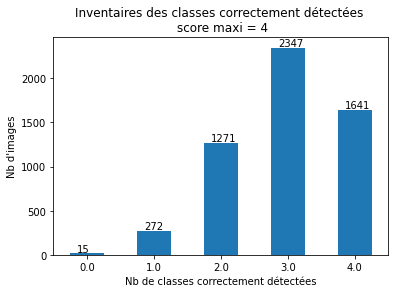

In [ ]:
# Initialisation et...
score = []
# ... calcul du score
for i in range(target.shape[0]):
  temp = np.dot(target.iloc[i].values, prediction.iloc[i].values) +  np.dot(-1+target.iloc[i].values, -1+prediction.iloc[i].values)
  score.append(temp)

# Ajout des résultats sous la colonne 'score' dans le dataframe
target['score'] = score

# Décompte des modalités : 0, 1, 2, 3 ou 4 classes bien prédites
resultat = target['score'].value_counts()

# Tracé du graphique
ax=resultat.sort_index().plot.bar(rot = 0)
plt.xlabel('Nb de classes correctement détectées')
plt.ylabel('Nb d\'images')
plt.title('Inventaires des classes correctement détectées \n score maxi = 4')

# Impression des valeurs directement sur le graphique
for p in ax.patches:
  ax.annotate('{}'.format(p.get_height()),
              (p.get_x() + 0.1, p.get_height() + 20))
plt.show()

On observe que 15 images sont mal prédites (aucune classe correctement prédite).  
Au total, les images mal évaluées représentent 5% de l'ensemble des images (0 ou 1 classe bien prédite).  

### **6.5 - Vérification de l'origine des images (train / test)**

Les 5% ci-dessus représentent approximativement la proportion d'images isolées au début et la proportion des images mal détectées.  
On va isoler les différentes classes de prédiction en fonction de leur ensemble d'origine (train ou test) afin de vérifier dans quelle mesure l'ensemble de test est sur-représenté dans les mauvaises prédictions.

On ajoute une origine 'train' ou 'test' à chaque image en fonction de sa provenance.

In [ ]:
origine=[]

for i,val in enumerate(target.index):
  if any(y_test.index == val):
    origine.append('test')
  else:
    origine.append('train')

# Ajout d'une colonne au dataframe
target['origine']=origine

Affichage du ratio d'appartenance à test / train en fonction de la classe de prédiction. On ajoute une indication du ratio train/test lors de la séparation des ensembles initiaux.

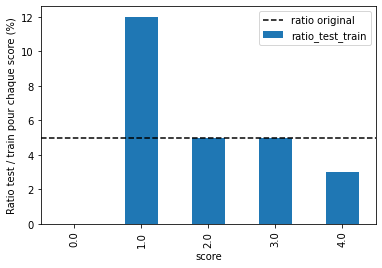

In [ ]:
# Décompte des train/ test pour chaque classe de détection
temp = target.groupby('origine')['score'].value_counts()
ratio_test_train = pd.DataFrame(temp['test']/temp['train']).rename(columns={'score':'ratio_test_train'})

# Affichage de l'histogramme
((ratio_test_train).fillna(0).round(2)*100).plot.bar()
plt.ylabel('Ratio test / train pour chaque score (%)')
plt.hlines(5, -0.5, 4.5,'k',
           linestyles='dashed' ,label='ratio original')
plt.legend()
plt.show()

Sans surprise, les images appartenant à test sont moins bien prédites que les images de train, même si toutes les images mal prédites appartiennent à l'ensemble train. Peut-être un biais dû au faible nombre d'images dans l'ensemble de test.  
La proportion d'images mal-prédites (score =1) de l'ensemble de test n'est probablement pas significative, étant donné le faible nombre d'images ayant un score de 1 (5% du total des images).

## **7 - Prédictions et analyses**

### **7.1 - Quelques prédictions**

On observe quelques images dont les labels réels sont comparés aux labels prédits.

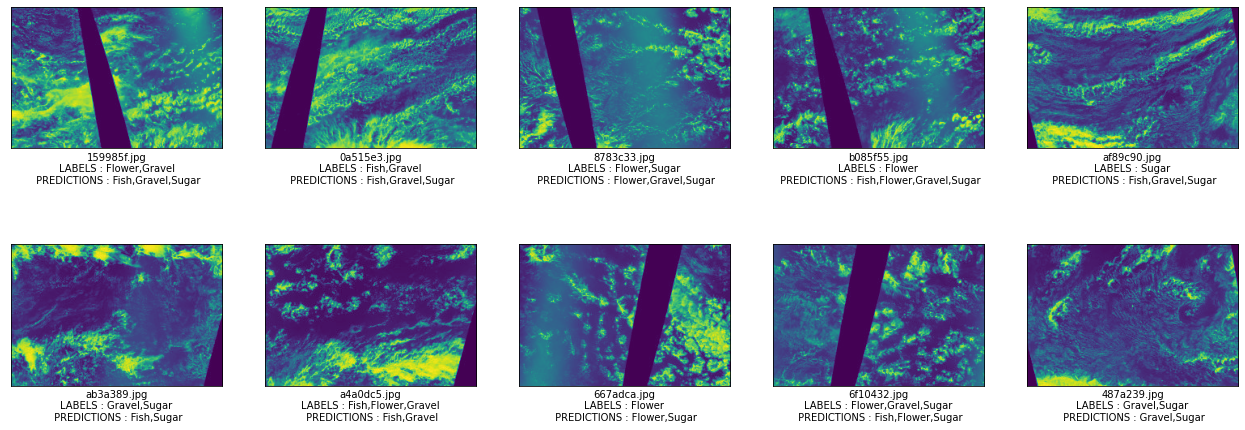

In [ ]:
plt.figure(figsize=(22,8))

j = 0
for i in range(10):
    j = j + 1
    plt.subplot(2,5,j)

    # Tirage au sort d'une image
    row = y_test.sample()
    imageName = row.index.values[0]
    indice = np.where(y_test.index==imageName)[0]

    # Affichage de l'image
    im = plt.imread(os.path.join(repTrain, imageName))
    plt.xlabel(imageName + '\nLABELS : '+ packages.get_labels(row.iloc[0,:].tolist())+'\n PREDICTIONS : ' + packages.get_labels(y_pred_final[indice,][0]))
    
    # Suppression des axes inutiles
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)
plt.show()

### **7.2 - Détermination d'un scoring individuel inter-classe par image**

Calcul du f1-score multilabel/multiclasse sur l'ensemble des images

In [ ]:
# Calcul du f1-score de chaque image
scores = f1_score(y_true = target.values[:,:4].astype('float').T,
                  y_pred = y_pred_final[:].T,
                  average = None, zero_division=0)

# On récupère les valeurs des classes réellement présentes / absentes
y_score = target.drop(columns=['score','origine'])
y_score = y_score.reset_index()

# On concatène avec les prédictions par classe.
pred_proba = pd.DataFrame.from_records(y_pred_final, columns=[s + '_prediction' for s in labels.values])
y_score = y_score.join(pred_proba)

#On joint également les scores calculés
y_score['score'] = scores
y_score.head(5)

image  Fish  Flower  ...  Gravel_prediction  Sugar_prediction     score
0  0011165.jpg   1.0     1.0  ...                0.0               0.0  0.666667
1  002be4f.jpg   1.0     1.0  ...                1.0               1.0  0.857143
2  0031ae9.jpg   1.0     1.0  ...                0.0               1.0  1.000000
3  0035239.jpg   0.0     1.0  ...                1.0               1.0  0.666667
4  003994e.jpg   1.0     0.0  ...                1.0               1.0  1.000000

[5 rows x 10 columns]

### **7.3 - Affichage de quelques images les moins bien prédites**

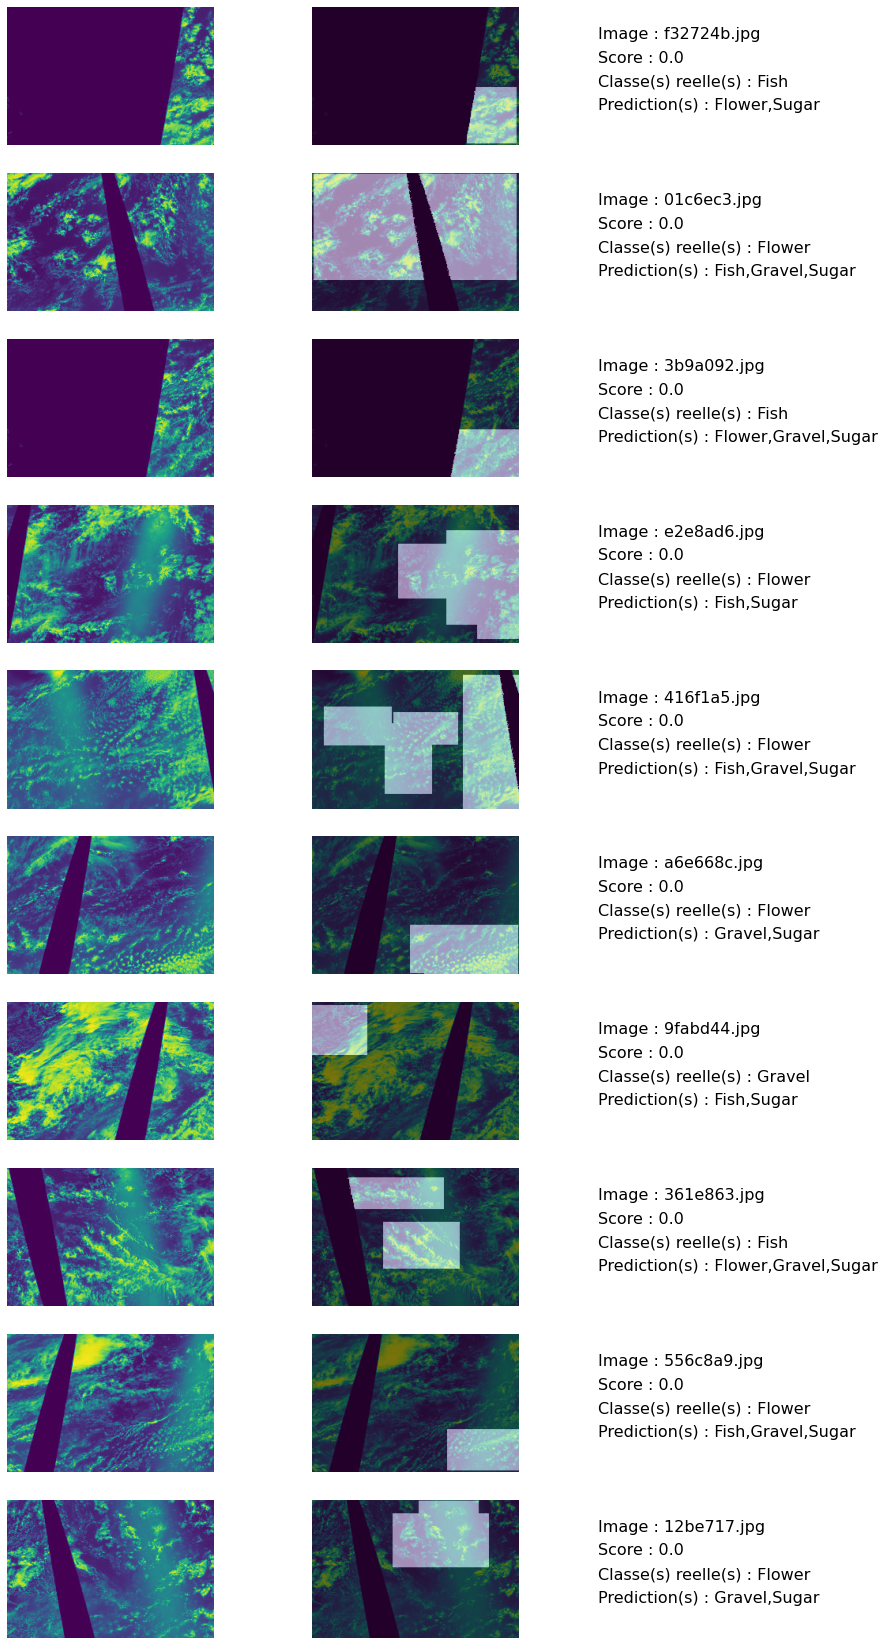

In [ ]:
# 10 images parmi les moins bien predites
flop10 = y_score.sort_values('score').head(10)
flop10 = flop10.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 30))

j= 0
for i in range(10):
    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, flop10.image[i]))
    plt.axis('off')
    plt.imshow(im)  

    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, flop10.image[i]))
    plt.axis('off')
    plt.imshow(im)    
    for index, row in train_partial[train_partial.image==flop10.image[i]].iterrows():
        mask = packages.rleToMask(row['EncodedPixels'])
        plt.imshow(cv2.resize(mask, (ty, tx)) , alpha=0.5, cmap="gray")  

    fontSize = 16
    plt.text(im.shape[1]+100, 40, 'Image : ' + flop10.image[i], fontsize=fontSize)
    plt.text(im.shape[1]+100, 70, 'Score : ' + str(flop10.score[i]), fontsize=fontSize)
    plt.text(im.shape[1]+100, 100, 'Classe(s) reelle(s) : ' + packages.get_labels(flop10.iloc[i,1:5]), fontsize=fontSize) 
    plt.text(im.shape[1]+100, 130, 'Prediction(s) : ' + packages.get_labels(flop10.iloc[i,5:9]), fontsize=fontSize)       

plt.show()

### **7.4 - Affichage de quelques images les mieux prédites**

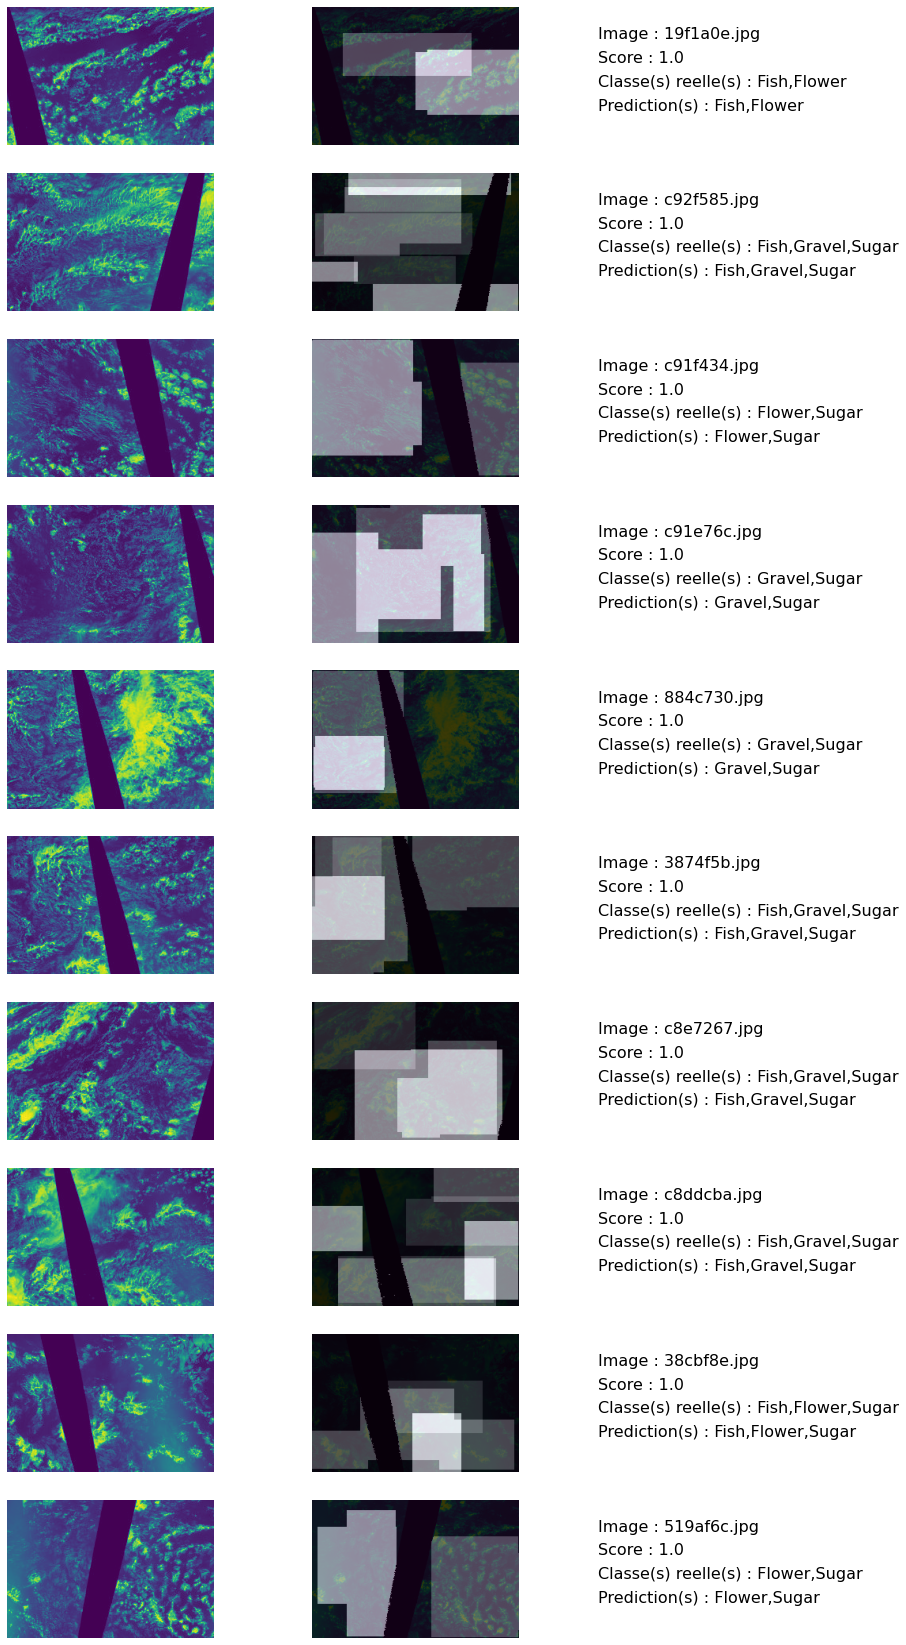

In [ ]:
# 10 images parmi les mieux prédites
top10 = y_score.sort_values('score').tail(10)
top10 = top10.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 30))

j= 0
for i in range(10):
    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, top10.image[i]))
    plt.axis('off')
    plt.imshow(im)  

    j=j+1
    plt.subplot(10,2,j)
    im = plt.imread(os.path.join(repTrain, top10.image[i]))
    plt.axis('off')
    plt.imshow(im)    
    for index, row in train_partial[train_partial.image==top10.image[i]].iterrows():
        mask = packages.rleToMask(row['EncodedPixels'])
        plt.imshow(cv2.resize(mask, (ty, tx)) , alpha=0.5, cmap="gray")  

    fontSize = 16
    plt.text(im.shape[1]+100, 40, 'Image : ' + top10.image[i], fontsize=fontSize)
    plt.text(im.shape[1]+100, 70, 'Score : ' + str(top10.score[i]), fontsize=fontSize)
    plt.text(im.shape[1]+100, 100, 'Classe(s) reelle(s) : ' + packages.get_labels(top10.iloc[i,1:5]), fontsize=fontSize) 
    plt.text(im.shape[1]+100, 130, 'Prediction(s) : ' + packages.get_labels(top10.iloc[i,5:9]), fontsize=fontSize)       

plt.show()

### **7.5 - Correlation nombre de classes / score de prédiction**

On constate que, dans une certaine mesure, moins il y a de zones nuageuses à 
prédire dans une image, plus le score de prédiction est faible. Ceci est statistiquement compréhensible et prévisible.

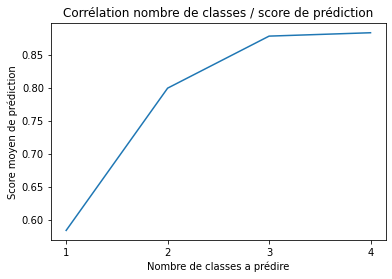

In [ ]:
y_score['nb_classes'] = y_score.Fish + y_score.Flower + y_score.Gravel + y_score.Sugar
setMoyen = y_score.groupby('nb_classes').mean()

plt.plot(setMoyen.index, setMoyen.score)
plt.xticks(np.arange(min(setMoyen.index), max(setMoyen.index)+1, 1.0))
plt.xlabel('Nombre de classes a prédire')
plt.ylabel('Score moyen de prédiction')
plt.title('Corrélation nombre de classes / score de prédiction')
plt.show()

### **7.6 - Correlation surface moyenne des zones / score de prédiction**

Il est difficile d'établir un lien direct entre la taille des surfaces à prédire et la qualité de prédiction. On constate néanmoins sur les violons ci-dessous que les classes bien prédites ont une surface relativement homogène. Ceci se traduit par une proéminence plus marquée autour de la médiane pour les scores moyens et bons.

Définition de fonctions préalables :  
* Calcul de la surface moyenne de zones segmentées

In [ ]:
def surfaceMoyenne(image):

    surface_total = 0
    nb_surface = 0

    for i, row in train_partial[train_partial.image==image].iterrows():
        rle = row['EncodedPixels']

        #Initialisation de la surface courante
        surface_total += packages.surfaceFromRle(row['EncodedPixels'])
        nb_surface += 1

    return surface_total / nb_surface

* Classification arbitraire des scores en mauvais / moyen / bon

In [ ]:
def score(data):
    if data <= 0.4 :
        return 'mauvais'      
    elif data <= 0.8 :  
        return 'moyen'      
    else:
        return 'bon'

Calcul des surfaces moyennes rapprochées du score de prédiction

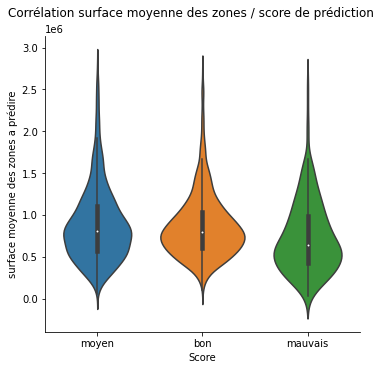

In [ ]:
y_score['surface_moyenne'] = y_score.apply(lambda row : surfaceMoyenne(row['image']), axis = 1)
y_score['cat_score'] = y_score['score'].apply(score)

ax = sns.catplot(x=y_score['cat_score'], 
                 y='surface_moyenne',
                 data=y_score, 
                 kind = 'violin');
ax.set_axis_labels("Score", "surface moyenne des zones a prédire")

ax.fig.subplots_adjust(top=0.9) 
ax.fig.suptitle('Corrélation surface moyenne des zones / score de prédiction') ;

### **7.7 - Distribution des classes de nuages par scores de prédiction**

On constate une sur-représentation de la classe "Sugar" dans les images ayant obtenues un score de prédiction bon ou moyen. A l'inverse une sous-représentation de cette classe pour les images ayant obtenues un faible score. La classe Flower semble suivre la logique inverse.<br>
Il faut neanmoins mentionner que la différence d'échelle dûe au petit nombre d’images aux scores mauvais rend les tendances statistiquement difficiles à analyser.

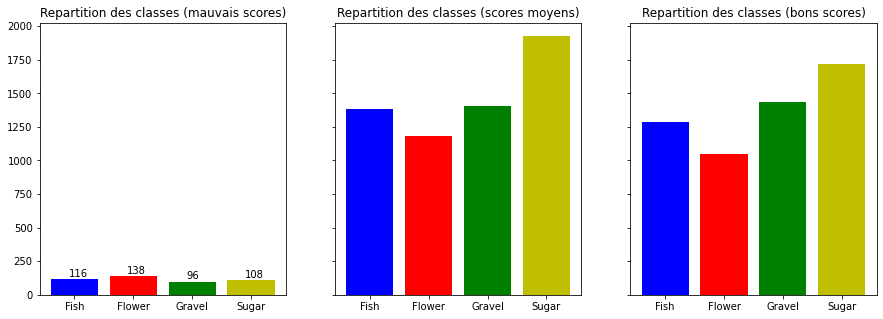

In [ ]:
mauvaisScores =  y_score[y_score.cat_score == 'mauvais']
moyenScores =  y_score[y_score.cat_score == 'moyen']
bonScores =  y_score[y_score.cat_score == 'bon']

colors = ['b','r','g', 'y']

fig, ax = plt.subplots(1,3,figsize=(15, 5),sharey=True)

ax[0].bar(labels.values, mauvaisScores[labels.values].sum(), color=colors)
ax[0].set_title("Repartition des classes (mauvais scores)")

ax[1].bar(labels.values, moyenScores[labels.values].sum(), color=colors)
ax[1].set_title("Repartition des classes (scores moyens)")

ax[2].bar(labels.values, bonScores[labels.values].sum(), color=colors)
ax[2].set_title("Repartition des classes (bons scores)")

#Ajout des valeurs pour les mauvais scores
for p in ax[0].patches:
    ax[0].annotate('{:.0f}'.format(p.get_height()),
              (p.get_x() + 0.3, p.get_height() + 20))
  
plt.show()

## **8 - Conclusion et ouverture**

Dans le cadre de cette phase 2 du projet (multi-classification), nous pouvons tirer les conclusions suivantes :  
* les images en nuances de gris permettent de faire une évaluation correcte de la présence des différentes classes, ce point confirme la tendance identifiée lors de la phase 1,
* un classificateur CNN permet d'identifier correctement la présence ou l'absence des différentes classes de nuages du jeu d'entraînement, 
* la présence des images de mauvaises qualités ne nuit pas a la classification, par ailleurs l'augmentation des images ne semble pas apporter de précision supplémentaire. A contrario, l'absence d'augmentation n'amène pas de sur-apprentissage. Ceci est peut-être dû à la nature diffuse des images,
* un format d'entrée réduit d'un facteur 8 est suffisant pour classifier les images de manière correcte,
* enfin un grand nombre de modèles ont été testés, mais il s'avère que les modèles les plus simples ont le mieux performé. 

Il pourrait être pertinent de tester la réaction du modèle sur des images vides de toute formation nuageuse. 

La phase 3 du projet va consister à identifier les régions précises dans lesquelles les classes de nuages sont présentes.
